In [1]:
from spectral_cube import SpectralCube

In [2]:
from astropy import units as u

In [3]:
cube = SpectralCube.read('/orange/adamginsburg/orion/2016.1.00165.S/external/full_OrionSourceI_B6_spw1_lines_cutout.fits')
cube

VaryingResolutionSpectralCube with shape=(1920, 1250, 1250) and unit=Jy / beam:
 n_x:   1250  type_x: RA---SIN  unit_x: deg    range:    83.809793 deg:   83.811187 deg
 n_y:   1250  type_y: DEC--SIN  unit_y: deg    range:    -5.375852 deg:   -5.374464 deg
 n_s:   1920  type_s: FREQ      unit_s: Hz     range: 231834857246.900 Hz:233708832546.243 Hz

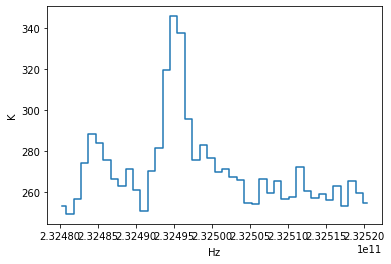

In [4]:
cube.spectral_slab(232.48*u.GHz, 232.52*u.GHz)[:, 640, 650].to(u.K).quicklook()

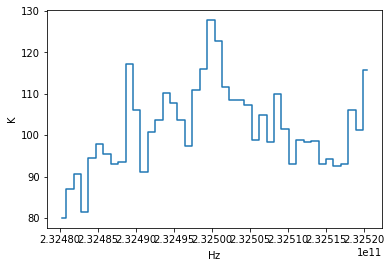

In [5]:
cube.spectral_slab(232.48*u.GHz, 232.52*u.GHz)[:, 660, 640].to(u.K).quicklook()

In [6]:
%matplotlib inline
import pylab as pl
pl.rcParams['figure.facecolor'] = 'w'
from spectral_cube import SpectralCube
from astropy import units as u
from astropy.visualization import quantity_support
quantity_support()

<astropy.visualization.units.quantity_support.<locals>.MplQuantityConverter at 0x2ae58f27f1f0>

In [7]:
from astropy.table import Table
from astropy import table

In [8]:
import pprint

In [9]:
import scipy, scipy.ndimage

In [10]:
import numpy as np
import os
import glob
from astropy import constants, units as u, table, stats, coordinates, wcs, log, coordinates as coord
import radio_beam
import pyspeckit
import pylab as pl
from astroquery.splatalogue.utils import minimize_table as mt
import sys
sys.path.append('/orange/adamginsburg/salt/Orion_ALMA_2016.1.00165.S/analysis')
import lines
import paths
from salt_tables import (salt_tables, salt_table_names, SO, SO2, HCl, sis_tables, AlCl, AlF, Al37Cl,
                         NaF, AlO, AlOH, NaCN, CaS, CaO)

In [11]:
import regions
from astropy import units as u, coordinates
cen = coordinates.SkyCoord(83.810486281, -5.37517214, unit=(u.deg, u.deg), frame='icrs')
reg = regions.Regions([regions.RectangleSkyRegion(cen, 0.53*u.arcsec, 0.34*u.arcsec, 52*u.deg)])
#    box(83.810486281, -5.375172145, 0.3368", 0.5281", 322.67123) # color=#2EE6D6 width=2

#reg2 = regions.Regions.read('cutout2.reg')
#reg3 = regions.Regions.read('cutout3.reg')
#regvsm = regions.Regions.read('verysmall.reg')
#regvvsm = regions.Regions.read('innerdiskbox.reg')

# NaCl Stackl

In [12]:
from spectral_cube.analysis_utilities import stack_cube

In [13]:
nacltables = salt_tables[3:5]
#nacltables[0]

In [14]:
import spectral_cube.analysis_utilities
import imp
imp.reload(spectral_cube.analysis_utilities)
from spectral_cube.analysis_utilities import stack_cube

In [15]:
flist = (glob.glob('/orange/adamginsburg/orion/2016.1.00165.S/external/full_OrionSourceI_B6_spw*_lines_cutout.fits'))

In [16]:
flist

['/orange/adamginsburg/orion/2016.1.00165.S/external/full_OrionSourceI_B6_spw1_lines_cutout.fits',
 '/orange/adamginsburg/orion/2016.1.00165.S/external/full_OrionSourceI_B6_spw0_lines_cutout.fits',
 '/orange/adamginsburg/orion/2016.1.00165.S/external/full_OrionSourceI_B6_spw2_lines_cutout.fits',
 '/orange/adamginsburg/orion/2016.1.00165.S/external/full_OrionSourceI_B6_spw3_lines_cutout.fits']

In [17]:
regn = "co1"
# don't need to subcube b/c reg = cutout = co1
cubes = [SpectralCube.read(fn, use_dask=True)#.subcube_from_regions(reg3)
         for fn in (glob.glob('/orange/adamginsburg/orion/2016.1.00165.S/external/full_OrionSourceI_B6_spw*_lines_cutout_smaller.fits'))]
for ii,cube in enumerate(cubes):
    # continuum subtract
    with cube.use_dask_scheduler('threads', num_workers=8):
        cube.allow_huge_operations = True
        cubes[ii] = cube - cube.percentile(25, axis=0)
cubes

[DaskSpectralCube with shape=(1920, 156, 148) and unit=Jy / beam and chunk size (640, 156, 148):
  n_x:    148  type_x: RA---SIN  unit_x: deg    range:    83.810404 deg:   83.810569 deg
  n_y:    156  type_y: DEC--SIN  unit_y: deg    range:    -5.375258 deg:   -5.375086 deg
  n_s:   1920  type_s: FREQ      unit_s: Hz     range: 231834857246.900 Hz:233708832546.243 Hz,
 DaskSpectralCube with shape=(1920, 156, 148) and unit=Jy / beam and chunk size (640, 156, 148):
  n_x:    148  type_x: RA---SIN  unit_x: deg    range:    83.810404 deg:   83.810569 deg
  n_y:    156  type_y: DEC--SIN  unit_y: deg    range:    -5.375258 deg:   -5.375086 deg
  n_s:   1920  type_s: FREQ      unit_s: Hz     range: 214277229834.040 Hz:216151205133.500 Hz,
 DaskSpectralCube with shape=(1920, 156, 148) and unit=Jy / beam and chunk size (640, 156, 148):
  n_x:    148  type_x: RA---SIN  unit_x: deg    range:    83.810404 deg:   83.810569 deg
  n_y:    156  type_y: DEC--SIN  unit_y: deg    range:    -5.375258 deg:

In [18]:
linelist = np.concatenate([data['Freq'][(data['vu'] <= 3) &
                                          np.any([((data['Freq'].quantity > cube.spectral_extrema[0]) &
                                                   (data['Freq'].quantity < cube.spectral_extrema[1]))
                                                 for cube in cubes],
                                                 axis=0)].quantity
                             for data in nacltables])
linenames = np.concatenate( [data['Species'][(data['vu'] <= 3) &
                                          np.any([((data['Freq'].quantity > cube.spectral_extrema[0]) &
                                                   (data['Freq'].quantity < cube.spectral_extrema[1]))
                                                 for cube in cubes],
                                                 axis=0)]
                             for data in nacltables] )
(linelist, linenames)

(<Quantity [217.980231, 230.779167, 232.509977, 214.938711, 229.246046] GHz>,
 array(['23Na-35Clv=2-2 J=17-16', '23Na-35Clv=2-2 J=18-17',
        '23Na-35Clv=1-1 J=18-17', '23Na-37Clv=1-1 J=17-16',
        '23Na-37Clv=0-0 J=18-17'], dtype='<U24'))